### scikit-mobility tutorials

# 4 - Flow models

Generative models of collective spatial flows.

- [Gravity](#Gravity)
    - [Singly Constrained](#Singly-constrained)
    - [Globally Constrained](#Globally-constrained)
- [Radiation](#Radiation)
- [Population Weighted Opportunities PWO](#Population-Weighted-Opportunities-PWO)
- [Rank Distance](#Rank-Distance)

In [1]:
import skmob
from skmob.utils import utils, constants

import pandas as pd
import geopandas as gpd
import numpy as np
import folium

In [2]:
tessellation = gpd.GeoDataFrame.from_file("data/NY_counties_2011.geojson")

fdf = skmob.FlowDataFrame.from_file("data/NY_commuting_flows_2011.csv",
                                    tessellation=tessellation, tile_id='tile_id', sep=",")

In [3]:
from skmob.models.epr import DensityEPR, Ditras

In [4]:
from skmob.models.markov_diary_generator import MarkovDiaryGenerator
from skmob.preprocessing import filtering, compression, detection, clustering

In [5]:
tdf = skmob.TrajDataFrame.from_file('./data/geolife_sample.txt.gz', 
                                     latitude='lat', longitude='lon', user_id='user', 
                                     datetime='datetime', sep=',')
ctdf = compression.compress(tdf)
stdf = detection.stops(ctdf)
cstdf = clustering.cluster(stdf)
cstdf[:5]

,lat,lng,datetime,uid,leaving_datetime,cluster
0,39.978253,116.327275,2008-10-23 06:01:05,1,2008-10-23 10:32:53,0
1,40.013819,116.306532,2008-10-23 11:10:09,1,2008-10-23 23:46:02,1
2,39.978987,116.326686,2008-10-24 00:10:39,1,2008-10-24 01:48:57,0
3,39.981316,116.310181,2008-10-24 01:56:47,1,2008-10-24 03:21:09,7
4,39.979580,116.313649,2008-10-24 03:26:35,1,2008-10-24 03:50:36,42


In [6]:
mdg = MarkovDiaryGenerator()
mdg.fit(cstdf, 2, lid='cluster')
    

100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


In [7]:
start_time = pd.to_datetime('2019/01/01 08:00:00')
end_time = pd.to_datetime('2019/01/14 08:00:00')
depr = Ditras(mdg)

In [8]:
tdf = depr.generate(start_time, end_time, tessellation, relevance_column='population',
                    n_agents=3, od_matrix=None, verbose=True)

  0%|          | 0/3 [00:00<?, ?it/s]/Users/fs13378/sda3/projects/scikit_mobility/skmob/models/collective.py:47: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)
100%|██████████| 3/3 [00:00<00:00,  8.90it/s]


## depr

In [5]:
start_time = pd.to_datetime('2019/01/01 08:00:00')
end_time = pd.to_datetime('2019/01/14 08:00:00')
depr = DensityEPR()

In [6]:
tdf = depr.generate(start_time, end_time, tessellation, relevance_column='population',
                    n_agents=3, od_matrix=None, verbose=True)

  0%|          | 0/3 [00:00<?, ?it/s]/Users/fs13378/sda3/projects/scikit_mobility/skmob/models/collective.py:47: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)
100%|██████████| 3/3 [00:00<00:00,  2.89it/s]


In [7]:
from skmob.preprocessing import detection, clustering

In [9]:
dtdf = detection.stops(tdf)
ctdf = clustering.cluster(dtdf)

In [11]:
uid = 2
m = tdf[tdf['uid'] == uid].plot_trajectory()
ctdf[ctdf['uid'] == uid].plot_stops(map_f=m)

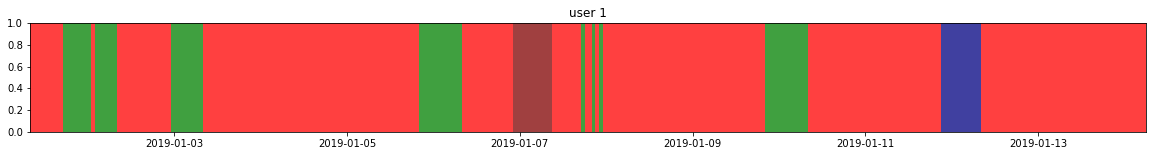

In [14]:
ctdf.plot_diary(user=1)

In [3]:
fdf.plot_flows(tiles='cartodbpositron')

## test

In [3]:
from skmob.utils.gislib import getDistanceByHaversine
from geopy.distance import distance

distfunc = (lambda p0,p1: distance(p0,p1).km)

In [4]:
p0 = (0., 0.)
p1 = (1., 0.)
getDistanceByHaversine(p0,p1), distance(p0,p1).km

(111.19492664455873, 110.57438855779878)

In [5]:

def generate_synthetic_flows_scGM(n_locations, weights, coordinates,\
        tot_outflows, deterrence_function, distfunc=distfunc):
    """
     Generate synthetic data accoding to the assumptions:
       1. Assume $n$ locations are randomly and uniformy distributed
       2. generate a random array of $w_i = T_i$
       3. generate the distance matrix $r_{ij}$
       4. generate the matrix $p_{ij}$
       5. generate a sample of $T_{ij}$ according to the multinomial distribution
    
     Returns:
        r : matrix of distances between all pairs of locations
        p : matrix of probabilities of one trip between all pairs of locations
        x : matrix of flows (one realization of the process)
        
    
     Example:
    
        n = 100
        n_locations = n
        weights = np.random.randint(100,10000, size=n)
        coordinates = 100.0*np.random.random(size=(n,2))
        tot_outflows = weights
        deterrence_function = (lambda x: np.exp(-x**1.5/50.0) )
    
    """
    n = n_locations
    w = weights
    ll = coordinates

    r = np.zeros(shape=(n,n))
    for i in range(n):
        for j in range(n):
            r[i,j] = distfunc(ll[i],ll[j])

    p = deterrence_function(r)
#     p -= np.eye(n)*np.diag(p)
    # replace diagonal with zeros
    np.fill_diagonal(p, 0.)
    

    tpw = np.transpose(p*w)
    p = np.transpose(tpw/sum(tpw))
    np.putmask(p,np.isnan(p),0.0)

    x = np.array([np.random.multinomial(tot_outflows[i], p[i]) for i in range(n)])

    return r, p, x

In [ ]:
def compute_gravity_score(distance_matrix, relevances):
    trip_probs_matrix = self._deterrence_func(distance_matrix, * self._deterrence_func_args)
    trip_probs_matrix = np.transpose(trip_probs_matrix * relevances ** self.destination_exp) * relevances ** self._origin_exp
    # put the NaN and Inf to 0.0
    np.putmask(trip_probs_matrix, np.isnan(trip_probs_matrix), 0.0)
    np.putmask(trip_probs_matrix, np.isinf(trip_probs_matrix), 0.0)
    return trip_probs_matrix

In [6]:
weights = tessellation['population'].fillna(0).values
len(weights), weights[:5]

(62, array([  81716,   99145,   50872, 1346176,   79693]))

In [7]:
tessellation[:4]

,tile_id,population,geometry
0,36019,81716,"POLYGON ((-74.006668 44.886017, -74.027389 44...."
1,36101,99145,"POLYGON ((-77.099754 42.274215, -77.0996569999..."
2,36107,50872,"POLYGON ((-76.25014899999999 42.296676, -76.24..."
3,36059,1346176,"POLYGON ((-73.707662 40.727831, -73.700272 40...."


In [8]:
coordinates = tessellation.geometry.apply(utils.get_geom_centroid, args=[True]).values
len(coordinates), coordinates[:4]

(62, array([list([44.647781630630625, -73.5064811981982]),
        list([42.37963118518518, -77.26606137037037]),
        list([42.260776836538454, -76.23450884615384]),
        list([40.73727142647059, -73.61467386764704])], dtype=object))

In [9]:
tot_outflows = fdf.groupby(by='origin', axis=0)['flow'].sum().fillna(0).values
len(tot_outflows), tot_outflows[:4]

(62, array([151587,  19146, 534582,  85362]))

In [10]:
np.random.seed(0)

deterrence_function = (lambda x: np.power(x, -2.) )
n = len(weights)

r,p,x = generate_synthetic_flows_scGM(n, weights, coordinates,\
        tot_outflows, deterrence_function, distfunc=distfunc)

/Users/fs13378/anaconda2/envs/skmob/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()


In [11]:
x[0,:]

array([    0,   535,   368,  5781,   683,   155,   624,  2796,  3172,
        1013,   484,   921,  9467,  9439,   424,  1443,   493,  3521,
        6346,  5589,   264,  1201,   174,   196, 12334,  1381,   514,
         906,   189,   674,  1706,  4156,   407,   251,  1842,  2456,
         667,   740,   101,  1370,  5494,   460,   686,  3075,   301,
        6924,   591,   456,   275,   632,  3483,  4990,  2391,   276,
        2510, 10566,   689,  1510,  3579,  5075,  5993,  6848])

## skmob

In [3]:
from skmob.models.migration import Gravity

In [4]:
# total outflows excluding self loops
tot_outflows = fdf[fdf['origin'] != fdf['destination']].groupby(by='origin', axis=0)['flow'].sum().fillna(0).values
tessellation[constants.TOT_OUTFLOW] = tot_outflows
tessellation[:4]

,tile_id,population,geometry,tot_outflow
0,36019,81716,"POLYGON ((-74.006668 44.886017, -74.027389 44....",29981
1,36101,99145,"POLYGON ((-77.099754 42.274215, -77.0996569999...",5319
2,36107,50872,"POLYGON ((-76.25014899999999 42.296676, -76.24...",295916
3,36059,1346176,"POLYGON ((-73.707662 40.727831, -73.700272 40....",8665


In [5]:
gravity_singly = Gravity(gravity_type='singly constrained')
print(gravity_singly)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")


In [6]:
np.random.seed(0)

scGM_fdf = gravity_singly.generate(tessellation, 
                                       tile_id_column='tile_id', 
                                       tot_outflows_column='tot_outflow', 
                                       relevance_column= 'population',
                                       out_format='flows')
scGM_fdf[:4]

100%|██████████| 62/62 [00:00<00:00, 186.80it/s]
/Users/fs13378/sda3/projects/scikit_mobility/skmob/models/migration.py:47: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)


,origin,destination,flow
0,36019,36101,112
1,36019,36107,55
2,36019,36059,1134
3,36019,36011,140


In [8]:
np.random.seed(0)

scGM_fdf = gravity_singly.generate(tessellation, 
                                       tile_id_column='tile_id', 
                                       tot_outflows_column='tot_outflow', 
                                       relevance_column= 'population',
                                       out_format='flows')
scGM_fdf[:4]

100%|██████████| 62/62 [00:00<00:00, 195.61it/s]
/Users/fs13378/sda3/projects/scikit_mobility/skmob/models/migration.py:47: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)


,origin,destination,flow
0,36019,36101,112
1,36019,36107,55
2,36019,36059,1134
3,36019,36011,140


In [6]:
from skmob.models import migration

In [7]:
distance_matrix = migration.compute_distance_matrix(tessellation, list(range(len(tessellation))))
relevances = tessellation['population'].values

100%|██████████| 62/62 [00:00<00:00, 168.98it/s]


In [12]:
pp = gravity_singly.compute_gravity_score(distance_matrix, relevances, relevances)

In [13]:
pp[0,:]

array([      0.        ,   51982.67985217,   34917.58683334,
        582688.79937514,   67445.93416162,   15216.19323392,
         63524.76982027,  286702.74065995,  308706.33798608,
         95108.60621273,   47048.16246399,   87522.28449049,
        943184.16390667,  947346.07416019,   39943.33431344,
        145250.44851674,   51953.7060941 ,  343949.58186517,
        637968.10565887,  560895.41854113,   27487.40373624,
        120808.90823681,   18472.4010667 ,   19816.65703725,
       1230629.57830081,  142194.67639631,   51485.16440799,
         92622.74514375,   20740.11117789,   72102.39820278,
        173512.15100761,  414428.54158445,   41636.96845409,
         25430.81425702,  185551.81716623,  240413.9994464 ,
         64609.9727403 ,   74818.27197731,   10940.41260567,
        130902.86846411,  538418.70295635,   49876.49709767,
         70607.28711536,  317401.37958747,   32444.00028954,
        698395.0709516 ,   57904.8502739 ,   43113.49398435,
         28713.33278604,

In [42]:
gravity_singly._deterrence_func( distance_matrix[0,:], *gravity_singly.deterrence_func_args) * relevances * relevances[0]

/Users/fs13378/sda3/projects/scikit_mobility/skmob/models/migration.py:47: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)


array([             inf,   51982.67985217,   34917.58683334,
        582688.79937514,   67445.93416162,   15216.19323392,
         63524.76982027,  286702.74065995,  308706.33798608,
         95108.60621273,   47048.16246399,   87522.28449049,
        943184.16390667,  947346.07416019,   39943.33431344,
        145250.44851674,   51953.7060941 ,  343949.58186517,
        637968.10565887,  560895.41854113,   27487.40373624,
        120808.90823681,   18472.4010667 ,   19816.65703725,
       1230629.57830081,  142194.67639631,   51485.16440799,
         92622.74514375,   20740.11117789,   72102.39820278,
        173512.15100761,  414428.54158445,   41636.96845409,
         25430.81425702,  185551.81716623,  240413.9994464 ,
         64609.9727403 ,   74818.27197731,   10940.41260567,
        130902.86846411,  538418.70295635,   49876.49709767,
         70607.28711536,  317401.37958747,   32444.00028954,
        698395.0709516 ,   57904.8502739 ,   43113.49398435,
         28713.33278604,

In [50]:
trip_probs_matrix = gravity_singly._deterrence_func(distance_matrix[0,:], *gravity_singly._deterrence_func_args)
# trip_probs_matrix = np.transpose(
#     trip_probs_matrix * relevances ** self.destination_exp) * relevances ** self._origin_exp
trip_probs_matrix = trip_probs_matrix * relevances ** gravity_singly.destination_exp * \
                    np.expand_dims(relevances[0] ** gravity_singly._origin_exp, axis=1)
# put the NaN and Inf to 0.0
np.putmask(trip_probs_matrix, np.isnan(trip_probs_matrix), 0.0)
np.putmask(trip_probs_matrix, np.isinf(trip_probs_matrix), 0.0)
trip_probs_matrix

/Users/fs13378/anaconda2/envs/skmob/lib/python3.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


array([      0.        ,   51982.67985217,   34917.58683334,
        582688.79937514,   67445.93416162,   15216.19323392,
         63524.76982027,  286702.74065995,  308706.33798608,
         95108.60621273,   47048.16246399,   87522.28449049,
        943184.16390667,  947346.07416019,   39943.33431344,
        145250.44851674,   51953.7060941 ,  343949.58186517,
        637968.10565887,  560895.41854113,   27487.40373624,
        120808.90823681,   18472.4010667 ,   19816.65703725,
       1230629.57830081,  142194.67639631,   51485.16440799,
         92622.74514375,   20740.11117789,   72102.39820278,
        173512.15100761,  414428.54158445,   41636.96845409,
         25430.81425702,  185551.81716623,  240413.9994464 ,
         64609.9727403 ,   74818.27197731,   10940.41260567,
        130902.86846411,  538418.70295635,   49876.49709767,
         70607.28711536,  317401.37958747,   32444.00028954,
        698395.0709516 ,   57904.8502739 ,   43113.49398435,
         28713.33278604,

In [9]:
gravity_singly.compute_gravity_score(distance_matrix[0,:], relevances[0] , relevances)

array([      0.        ,   51982.67985217,   34917.58683334,
        582688.79937514,   67445.93416162,   15216.19323392,
         63524.76982027,  286702.74065995,  308706.33798608,
         95108.60621273,   47048.16246399,   87522.28449049,
        943184.16390667,  947346.07416019,   39943.33431344,
        145250.44851674,   51953.7060941 ,  343949.58186517,
        637968.10565887,  560895.41854113,   27487.40373624,
        120808.90823681,   18472.4010667 ,   19816.65703725,
       1230629.57830081,  142194.67639631,   51485.16440799,
         92622.74514375,   20740.11117789,   72102.39820278,
        173512.15100761,  414428.54158445,   41636.96845409,
         25430.81425702,  185551.81716623,  240413.9994464 ,
         64609.9727403 ,   74818.27197731,   10940.41260567,
        130902.86846411,  538418.70295635,   49876.49709767,
         70607.28711536,  317401.37958747,   32444.00028954,
        698395.0709516 ,   57904.8502739 ,   43113.49398435,
         28713.33278604,

In [11]:
%timeit gravity_singly.generate(tessellation, \
                                       tile_id_column='tile_id', \
                                       tot_outflows_column='tot_outflow', \
                                       relevance_column= 'population',\
                                       out_format='flows')

313 ms ± 4.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
scGM_fdf['flow'].sum(), fdf['flow'].sum()

(2978046, 8831941)

In [37]:
m = scGM_fdf.plot_flows(min_flow=1000, tiles='cartodbpositron')

m
# m.save('/Users/fs13378/Desktop/m.html')

In [13]:
import matplotlib.pyplot as plt

In [14]:
xy = fdf.merge(scGM_fdf, on=['origin', 'destination'])[['flow_x', 'flow_y']].values

[]

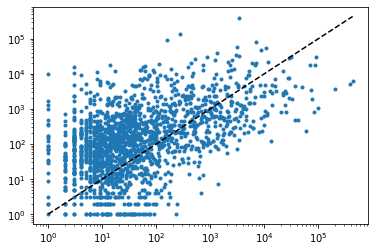

In [15]:
plt.plot(xy[:,0], xy[:,1], '.')

x = np.logspace(0, np.log10(np.max(xy)))
plt.plot(x, x, '--k')

plt.loglog()

# OLD

In [1]:
import skmob
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
tqdm.pandas()

In [2]:
from skmob.utils.gislib import load_spatial_tessellation

In [ ]:
st = load_spatial_tessellation('../data_test/test_flow_models/location2info_rome', positive_relevance=False)
len(st)

In [ ]:
st[0]

In [ ]:
rome_flows = pd.read_csv('../data_test/test_flow_models/rome_flows.csv')
print(len(rome_flows))
rome_flows.head()

# flowdataframe

In [1]:
import skmob
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
tqdm.pandas()

from skmob.utils.gislib import load_spatial_tessellation

In [2]:
gdf = gpd.read_file('./data/NY_counties_2011.geojson')
fdf = skmob.FlowDataFrame.from_file('./data/NY_commuting_flows_2011.csv', sep=',', tile_id='tile_id',
                                    origin='origin', destination='destination', tessellation=gdf)

In [3]:
gdf = gpd.read_file('./data/NY_counties_2011.geojson')
print(len(gdf))
gdf[:4]

62


,tile_id,population,geometry
0,36019,81716,"POLYGON ((-74.006668 44.886017, -74.027389 44...."
1,36101,99145,"POLYGON ((-77.099754 42.274215, -77.0996569999..."
2,36107,50872,"POLYGON ((-76.25014899999999 42.296676, -76.24..."
3,36059,1346176,"POLYGON ((-73.707662 40.727831, -73.700272 40...."


In [4]:
!head ./data/NY_commuting_flows_2011.csv

flow,origin,destination
121606,36001,36001
5,36001,36005
29,36001,36007
11,36001,36017
30,36001,36019
728,36001,36021
38,36001,36023
6,36001,36025
183,36001,36027


In [7]:
fdf = skmob.FlowDataFrame.from_file('./data/NY_commuting_flows_2011.csv', 
                                    sep=',', tile_id='tile_id',
                                    origin='origin', destination='destination', 
                                    tessellation=gdf)
fdf[:4]

,flow,origin,destination
0,121606,36001,36001
1,5,36001,36005
2,29,36001,36007
3,11,36001,36017


## Gravity

### Singly constrained

In [1]:
import skmob
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
tqdm.pandas()

from skmob.utils.gislib import load_spatial_tessellation

In [2]:
gdf = gpd.read_file('./data/NY_counties_2011.geojson')
fdf = skmob.FlowDataFrame.from_file('./data/NY_commuting_flows_2011.csv', 
                                    sep=',', tile_id='tile_id',
                                    origin='origin', destination='destination', 
                                    tessellation=gdf)

In [3]:
from skmob.models.migration import Gravity

In [4]:
gravity_singly = Gravity(gravity_type='singly constrained')
print(gravity_singly)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="singly constrained")


In [5]:
gravity_singly.fit(st, rome_flows.head(10))
print(gravity_singly)

NameError: name 'st' is not defined

In [9]:
gravity_singly.fit(st, rome_flows.head(1000))
print(gravity_singly)

100%|██████████| 1000/1000 [00:00<00:00, 5993.98it/s]


Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-0.46540196266829603], origin_exp=1.0, destination_exp=0.03017564316349213, gravity_type="singly constrained")


In [10]:
flows_singly = gravity_singly.generate(st, out_format='flows')
flows_singly

100%|██████████| 1358/1358 [00:01<00:00, 776.18it/s] 
/data2/scikit-mobility-library/skmob/models/migration.py:41: RuntimeWarning: divide by zero encountered in power
  return np.power(x, exponent)
/data2/scikit-mobility-library/skmob/models/migration.py:187: RuntimeWarning: invalid value encountered in true_divide
  trip_probs_matrix = np.transpose(trip_probs_matrix / np.sum(trip_probs_matrix, axis=1))


ValueError: sum(pvals[:-1]) > 1.0

In [11]:
probs_singly = gravity_singly.generate(st, out_format='probabilities')
probs_singly

100%|██████████| 1358/1358 [00:01<00:00, 774.05it/s] 


ValueError: sum(pvals[:-1]) > 1.0

### Globally constrained

In [12]:
gravity_globally = Gravity(gravity_type='globally constrained')
print(gravity_globally)

Gravity(name="Gravity model", deterrence_func_type="power_law", deterrence_func_args=[-2.0], origin_exp=1.0, destination_exp=1.0, gravity_type="globally constrained")


In [13]:
gravity_globally.fit(st, rome_flows.head(1000))
print(gravity_globally)

  0%|          | 0/1000 [00:00<?, ?it/s]/data2/scikit-mobility-library/skmob/models/migration.py:226: RuntimeWarning: divide by zero encountered in log
  sc_vars = [np.log(weight_origin)]
100%|██████████| 1000/1000 [00:00<00:00, 8921.00it/s]
/data2/scikit-mobility-library/skmob_dev/lib/python3.5/site-packages/numpy-1.16.0rc2-py3.5-linux-x86_64.egg/numpy/core/_methods.py:155: RuntimeWarning: invalid value encountered in subtract
  out


MissingDataError: exog contains inf or nans

In [14]:
flows_globally = gravity_globally.generate(st, out_format='flows')
flows_globally

100%|██████████| 1358/1358 [00:01<00:00, 775.74it/s] 


array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,  561,  329],
       [   0,    0,    0, ...,  550,    0, 1251],
       [   0,    0,    0, ...,  312, 1268,    0]])

In [15]:
probs_globally = gravity_globally.generate(st, out_format='probabilities')
probs_globally

100%|██████████| 1358/1358 [00:01<00:00, 775.73it/s] 


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.56831156e-04, 9.11241667e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.56831156e-04, 0.00000000e+00, 3.72196717e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.11241667e-05, 3.72196717e-04, 0.00000000e+00]])

## Radiation

In [16]:
from skmob.models.migration import Radiation

In [17]:
radiation = Radiation()
flows_avg = radiation.generate(st, out_format='flows_average')
flows_smp = radiation.generate(st, out_format='flows_sample')

100%|██████████| 1358/1358 [00:02<00:00, 501.11it/s]


In [18]:
flows_avg

array([[   8.,    9.,    0.],
       [   8.,    7.,    0.],
       [   8.,  306.,    0.],
       ...,
       [1357.,  180.,    0.],
       [1357.,  178.,    0.],
       [1357.,  181.,    0.]])

In [19]:
flows_smp

array([[   8.,    9.,    0.],
       [   8.,    7.,    0.],
       [   8.,  306.,    0.],
       ...,
       [1357.,  180.,    0.],
       [1357.,  178.,    0.],
       [1357.,  181.,    0.]])

## Population Weighted Opportunities PWO

In [ ]:
PopulationWeightedOpportunities

## Rank Distance

In [ ]:
RankDistance